# Option Pricing using Monte Carlo Methods

We want our code to run quickly. An example is Monte Carlo. We explore ways to make the code as fast as possible.

## Analytical Formula

In [21]:
from math import log, exp, sqrt
from scipy import stats

def priceCallOptionAnalytical(S0,K,T,r,sigma):
    d1 = (log(S0/K) + (r + 0.5*sigma*sigma)*T) /sigma*sqrt(T)
    d2 = (log(S0/K) + (r - 0.5*sigma*sigma)*T) /sigma*sqrt(T)    
    value = S0 * stats.norm.cdf(d1,0.0,1.0) - K * exp(-r*T) * stats.norm.cdf(d2,0.0,1.0)
    return value

In [22]:
S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2

In [23]:
priceCallOptionAnalytical(S0,K,T,r,sigma)

8.021352235143176

In [24]:
%timeit priceCallOptionAnalytical(S0,K,T,r,sigma)

232 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Monte Carlo Valuation in Basic Python

In [25]:
numPaths = 100000

In [26]:
# Pure python code valuing a call option
import random

def priceCallOptionMC(S0,K,T,r,sigma,numPaths):
    payOff = 0.0
    for i in range(0,numPaths):
        z = random.gauss(0.0,1.0)
        S = S0 * exp((r-sigma*sigma/2.0) * T + sigma * sqrt(T) * z)        
        payOff += max(0,S-K)
    value = payOff * exp(-r*T) / numPaths
    return value

In [27]:
priceCallOptionMC(S0,K,T,r,sigma,numPaths)

8.013892014566942

In [28]:
%timeit priceCallOptionMC(S0,K,T,r,sigma,numPaths)

255 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Monte Carlo Valuation in Numpy
When the function can be vectorised then Numpy can speed things up a lot

In [29]:
import numpy as np

def priceCallOptionMC_Numpy(S0,K,T,r,sigma,numPaths):
    z = np.random.normal(size=numPaths,loc=0.0,scale=1.0) 
    S = S0 * np.exp((r-sigma*sigma/2.0) * T + sigma * sqrt(T) * z)
    payoff = np.maximum(S-K,0)
    value = np.sum(payoff)/numPaths * np.exp(-r*T)     
    return value

In [30]:
priceCallOptionMC_Numpy(S0,K,T,r,sigma,numPaths)

7.995953234286477

In [31]:
%timeit priceCallOptionMC_Numpy(S0,K,T,r,sigma,numPaths)

11.6 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


But Numpy has a lognormal function

In [45]:
def priceCallOptionMC_Numpy_LN(S0,K,T,r,sigma,numPaths):
    S = S0 * np.random.lognormal((r-sigma*sigma/2.0) * T,sigma * sqrt(T), size=numPaths)
    payoff = np.maximum(S-K,0)
    value = np.sum(payoff)/numPaths * np.exp(-r*T)     
    return value

In [46]:
priceCallOptionMC_Numpy_LN(S0,K,T,r,sigma,numPaths)

8.002959319116568

In [47]:
%timeit priceCallOptionMC_Numpy_LN(S0,K,T,r,sigma,numPaths)

133 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Monte Carlo Valuation in Numba
Use the JIT compiler

In [48]:
from numba import jit

@jit 

def priceCallOptionMC_Numba(S0,K,T,r,sigma,numPaths):
    payOff = 0.0
    for i in range(0,numPaths):
        z = random.gauss(0.0,1.0)
        S = S0 * exp((r-sigma*sigma/2.0) * T + sigma * sqrt(T) * z)        
        payOff += max(0,S-K)
    value = payOff * exp(-r*T) / numPaths
    return value

In [49]:
priceCallOptionMC_Numba(S0,K,T,r,sigma,numPaths)

8.025172534523678

In [50]:
%timeit priceCallOptionMC_Numba(S0,K,T,r,sigma,numPaths)

79.1 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Convergence Analysis

In [51]:
paths = []
error = []

exactPrice = priceCallOptionAnalytical(S0,K,T,r,sigma)
    
for i in range(5,100):
    numPaths = 100 * i*i
    mcPrice = priceCallOptionMC_Numba(S0,K,T,r,sigma,numPaths)
    e = (mcPrice - exactPrice)
    paths.append(numPaths)
    error.append(e)

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Error in Option Price')

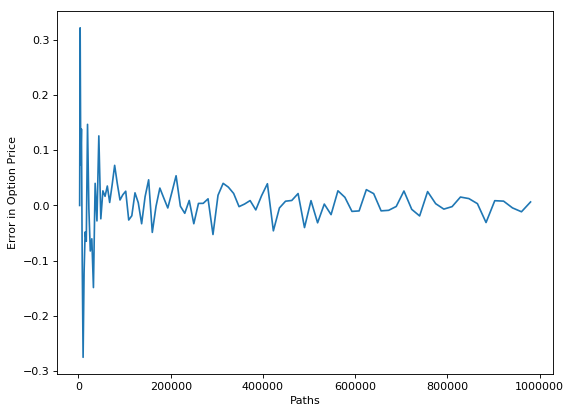

In [53]:
plt.figure(figsize=(8,6), dpi=80)
plt.plot(paths,error)
plt.xlabel('Paths')
plt.ylabel('Error in Option Price')